# Create, evaluate, and score a time series forecasting model

## Introduction

This notebook shows the Microsoft Fabric end-to-end data science workflow for a time series forecasting model. This scenario uses historic sales data to predict the total monthly sales of properties in New York City.

Time series forecasting predicts future values, based on historical data. This is a common, important part of business operations. This notebook shows tools and methods that can apply to other forecasting tasks: weather, sales numbers, stock prices, capacity planning, etc. 

This notebook covers these topics:

1. Install custom library resources
2. Load the data
3. Examine and process the data through exploratory data analysis
4. Train a machine learning model with `Prophet` - an open source software package - and track experiments using MLflow and the Fabric Autologging feature
5. Save the final machine learning model, and make predictions

## Prerequisites
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You'll download data from a public blob, then store the data in the lakehouse.

## Step 1: Install custom libraries


When you develop a machine learning model, or you handle ad-hoc data analysis, you may need to quickly install a custom library (e.g., `prophet` in this notebook) for the Apache Spark session. To do this, you have two choices. 

1. You can use the in-line installation capabilities (e.g., `%pip`, `%conda`, etc.) to quickly get started with new libraries. Note that this would only install the custom libraries in the current notebook, not in the workspace.

```python
# Use pip to install libraries
%pip install <library name>

# Use conda to install libraries
%conda install <library name>
```

2. Alternatively, you can create a Fabric environment, install libraries from public sources or upload custom libraries to it, and then your workspace admin can attach the environment as the default for the workspace. All the libraries in the environment will then become available for use in any notebooks and Spark job definitions in the workspace. For more information on environments, see [create, configure, and use an environment in Microsoft Fabric](https://aka.ms/fabric/create-environment).

For this notebook, you'll use `%pip install` to install the `prophet` library. Note that the PySpark kernel will restart after `%pip install`. This means that you must install the library before you run any other cells.

In [ ]:
# Use pip to install Prophet
%pip install prophet

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 68, Finished, Available)


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: /nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Load the data

#### Dataset

This notebook uses the NYC Property Sales data dataset. It covers data from 2003 to 2015, published by the NYC Department of Finance on the [NYC Open Data Portal](https://opendata.cityofnewyork.us/). 

The dataset includes a record of every building sale in the New York City property market, within a thirteen year period. Refer to the [Glossary of Terms for Property Sales Files](https://www1.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf) for a definition of the columns in the dataset.

|borough|neighborhood|building_class_category|tax_class|block|lot|eastment|building_class_at_present|address|apartment_number|zip_code|residential_units|commercial_units|total_units|land_square_feet|gross_square_feet|year_built|tax_class_at_time_of_sale|building_class_at_time_of_sale|sale_price|sale_date|
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
|Manhattan|ALPHABET CITY|07  RENTALS - WALKUP APARTMENTS|0.0|384.0|17.0||C4|225 EAST 2ND   STREET||10009.0|10.0|0.0|10.0|2145.0|6670.0|1900.0|2.0|C4|275000.0|2007-06-19|
|Manhattan|ALPHABET CITY|07  RENTALS - WALKUP APARTMENTS|2.0|405.0|12.0||C7|508 EAST 12TH   STREET||10009.0|28.0|2.0|30.0|3872.0|15428.0|1930.0|2.0|C7|7794005.0|2007-05-21|

The goal is to build a model that forecasts the monthly total sales, based on historical data. For this, you'll use [Prophet](https://facebook.github.io/prophet/), an open source forecasting library developed by Facebook. Prophet is based on an additive model, where non-linear trends are fit with daily, weekly, and yearly seasonality, and holiday effects. Prophet works best on time series datasets that have strong seasonal effects, and several seasons of historical data. Additionally, Prophet robustly handles missing data, and data outliers.

Prophet uses a decomposable time series model, consisting of three components:
- **trend**: Prophet assumes a piece-wise constant rate of growth, with automatic change point selection
- **seasonality**: By default, Prophet uses Fourier Series to fit weekly and yearly seasonality
- **holidays**: Prophet requires all past and future occurrences of holidays. If a holiday doesn't repeat in the future, Prophet will not include it in the forecast.

This notebook aggregates the data on a monthly basis, so it ignores the holidays.

Read [the official paper](https://peerj.com/preprints/3190/) for more information about the Prophet modeling techniques.

#### Download the dataset, and upload to a lakehouse

The data source consists of fifteen `.csv` files. These files contain property sales records from five boroughs in New York, between 2003 and 2015. For convenience, the `nyc_property_sales.tar` file holds all of these `.csv` files, compressing them into one file. A publicly-available blob storage hosts this `.tar` file.


> [!TIP]
> With the parameters shown in this code cell, you can easily apply this notebook to different datasets.


In [ ]:
URL = "https://synapseaisolutionsa.blob.core.windows.net/public/NYC_Property_Sales_Dataset/"
TAR_FILE_NAME = "nyc_property_sales.tar"
DATA_FOLDER = "Files/NYC_Property_Sales_Dataset"
TAR_FILE_PATH = f"/lakehouse/default/{DATA_FOLDER}/tar/"
CSV_FILE_PATH = f"/lakehouse/default/{DATA_FOLDER}/csv/"

EXPERIMENT_NAME = "aisample-timeseries" # MLflow experiment name

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 70, Finished, Available)

This code downloads a publicly-available version of the dataset, and then stores that dataset in a Fabric Lakehouse.

> [!IMPORTANT]
> **Make sure you [add a lakehouse](https://aka.ms/fabric/addlakehouse) to the notebook before running it. Failure to do so will result in an error.**

In [ ]:
import os

if not os.path.exists("/lakehouse/default"):
    # Add a lakehouse if the notebook has no default lakehouse
    # A new notebook will not link to any lakehouse by default
    raise FileNotFoundError(
        "Default lakehouse not found, please add a lakehouse for the notebook."
    )
else:
    # Verify whether or not the required files are already in the lakehouse, and if not, download and unzip
    if not os.path.exists(f"{TAR_FILE_PATH}{TAR_FILE_NAME}"):
        os.makedirs(TAR_FILE_PATH, exist_ok=True)
        os.system(f"wget {URL}{TAR_FILE_NAME} -O {TAR_FILE_PATH}{TAR_FILE_NAME}")

    os.makedirs(CSV_FILE_PATH, exist_ok=True)
    os.system(f"tar -zxvf {TAR_FILE_PATH}{TAR_FILE_NAME} -C {CSV_FILE_PATH}")

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 71, Finished, Available)

2009_bronx.csv
2009_brooklyn.csv
2009_manhattan.csv
2009_queens.csv
2009_statenisland.csv
2010_bronx.csv
2010_brooklyn.csv
2010_manhattan.csv
2010_queens.csv
2010_statenisland.csv
2011_bronx.csv
2011_brooklyn.csv
2011_manhattan.csv
2011_queens.csv
2011_statenisland.csv
2012_bronx.csv
2012_brooklyn.csv
2012_manhattan.csv
2012_queens.csv
2012_statenisland.csv
2013_bronx.csv
2013_brooklyn.csv
2013_manhattan.csv
2013_queens.csv
2013_statenisland.csv
2014_bronx.csv
2014_brooklyn.csv
2014_manhattan.csv
2014_queens.csv
2014_statenisland.csv
2015_bronx.csv
2015_brooklyn.csv
2015_manhattan.csv
2015_queens.csv
2015_statenisland.csv
sales_2007_bronx.csv
sales_2007_brooklyn.csv
sales_2007_manhattan.csv
sales_2007_queens.csv
sales_2007_statenisland.csv
sales_2008_bronx.csv
sales_2008_brooklyn.csv
sales_2008_manhattan.csv
sales_2008_queens.csv
sales_2008_statenisland.csv
sales_bronx_03.csv
sales_bronx_04.csv
sales_bronx_05.csv
sales_bronx_06.csv
sales_brooklyn_03.csv
sales_brooklyn_04.csv
sales_broo

Start recording the run-time of this notebook.

In [ ]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 72, Finished, Available)

#### Set up the MLflow experiment tracking

To extend the MLflow logging capabilities, autologging automatically captures the values of input parameters and output metrics of a machine learning model during its training. This information is then logged to the workspace, where the MLflow APIs or the corresponding experiment in the workspace can access and visualize it. Visit [this resource](https://aka.ms/fabric-autologging) for more information about autologging.

In [ ]:
# Set up the MLflow experiment
import mlflow

mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Disable MLflow autologging

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 73, Finished, Available)

> [!NOTE]
> If you want to disable Microsoft Fabric autologging in a notebook session, call `mlflow.autolog()` and set `disable=True`.

#### Read raw date data from the lakehouse

In [ ]:
df = (
    spark.read.format("csv")
    .option("header", "true")
    .load("Files/NYC_Property_Sales_Dataset/csv")
)

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 74, Finished, Available)

## Step 3: Begin exploratory data analysis

To review the dataset, you could manually examine a subset of data to gain a better understanding of it. You can use the `display` function to print the DataFrame. You can also show the Chart views, to easily visualize subsets of the dataset.

In [ ]:
display(df)

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 75, Finished, Available)

SynapseWidget(Synapse.DataFrame, 8dd4f138-2f2b-4c6b-93c4-cad306638b15)

A manual review of the dataset leads to some early observations:

- Instances of $0.00 sales prices. According to the [Glossary of Terms](https://www.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf), this implies a transfer of ownership with no cash consideration. In other words, no cash flowed in the transaction. You should remove sales with $0.00 `sales_price` values from the dataset.

- The dataset covers different building classes. However, this notebook will only focus on residential buildings which, according to the [Glossary of Terms](https://www.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf), are marked as type "A". You should filter the dataset to include only residential buildings. To do this, include either the `building_class_at_time_of_sale` or the `building_class_at_present` columns. You must only include the `building_class_at_time_of_sale` data.

- The dataset includes instances where `total_units` values equal 0, or `gross_square_feet` values equal 0. You should remove all the instances where `total_units` or `gross_square_units` values equal 0.

- Some columns - for example, `apartment_number`, `tax_class`, `build_class_at_present`, etc. - have missing or NULL values. Assume that the missing data involves clerical errors, or non-existent data. The analysis does not depend on these missing values, so you can ignore them.

- The `sale_price` column is stored as a string, with a prepended "$" character. To proceed with the analysis, represent this column as a number. You should cast the `sale_price` column as integer.

#### Type conversion and filtering
To resolve some of the identified issues, import the required libraries.

In [ ]:
# Import libraries
import pyspark.sql.functions as F
from pyspark.sql.types import *

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 76, Finished, Available)

**Cast the sales data from string to integer**

Use regular expressions to separate the numeric portion of the string from the dollar sign (for example, in the string "\$300,000", split "$" and "300,000"), and then cast the numeric portion as an integer.

**Next, filter the data to only include instances that meet all of these conditions:**

1. The `sales_price` is greater than 0
2. The `total_units` is greater than 0
3. The `gross_square_feet` is greater than 0
4. The `building_class_at_time_of_sale` is of type A

In [ ]:
df = df.withColumn(
    "sale_price", F.regexp_replace("sale_price", "[$,]", "").cast(IntegerType())
)
df = df.select("*").where(
    'sale_price > 0 and total_units > 0 and gross_square_feet > 0 and building_class_at_time_of_sale like "A%"'
)

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 77, Finished, Available)

#### Aggregation on monthly basis

The data resource tracks property sales on a daily basis, but this approach is too granular for this notebook. Instead, aggregate the data on a monthly basis.

First, change the date values to show only month and year data. Note that the date values would still include the year data. You could still distinguish between, for example, December 2005 and December 2006.

Additionally, only keep the columns relevant to the analysis. These include `sales_price`, `total_units`, `gross_square_feet` and `sales_date`. You must also rename `sales_date` to `month`.

In [ ]:
monthly_sale_df = df.select(
    "sale_price",
    "total_units",
    "gross_square_feet",
    F.date_format("sale_date", "yyyy-MM").alias("month"),
)
display(monthly_sale_df)

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 78, Finished, Available)

SynapseWidget(Synapse.DataFrame, d6ea41db-11e0-4751-b3f1-fc57c16a0ec5)

Aggregate the `sale_price`, `total_units` and `gross_square_feet` values by month. Then, group the data by `month`, and sum all the values within each group. 

In [ ]:
summary_df = (
    monthly_sale_df.groupBy("month")
    .agg(
        F.sum("sale_price").alias("total_sales"),
        F.sum("total_units").alias("units"),
        F.sum("gross_square_feet").alias("square_feet"),
    )
    .orderBy("month")
)

display(summary_df)

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 79, Finished, Available)

SynapseWidget(Synapse.DataFrame, 9fe2741f-628d-401f-98b8-5124d2671ed9)

#### Pyspark to Pandas conversion

Pyspark DataFrames handle large datasets really well. However, due to data aggregation, the DataFrame size is much smaller. This suggests that you can now use pandas DataFrames.

This code casts the dataset from a pyspark DataFrame to a pandas DataFrame.

In [ ]:
import pandas as pd

df_pandas = summary_df.toPandas()
display(df_pandas)

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 80, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


SynapseWidget(Synapse.DataFrame, ada62ded-cbdc-4fff-b054-1864c7426931)

#### Visualization

You can examine the property trade trend of New York City to better understand the data. This leads to insights into potential patterns and seasonality trends. Learn more about Microsoft Fabric data visualization at [this](https://aka.ms/fabric/visualization) resource.

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 81, Finished, Available)

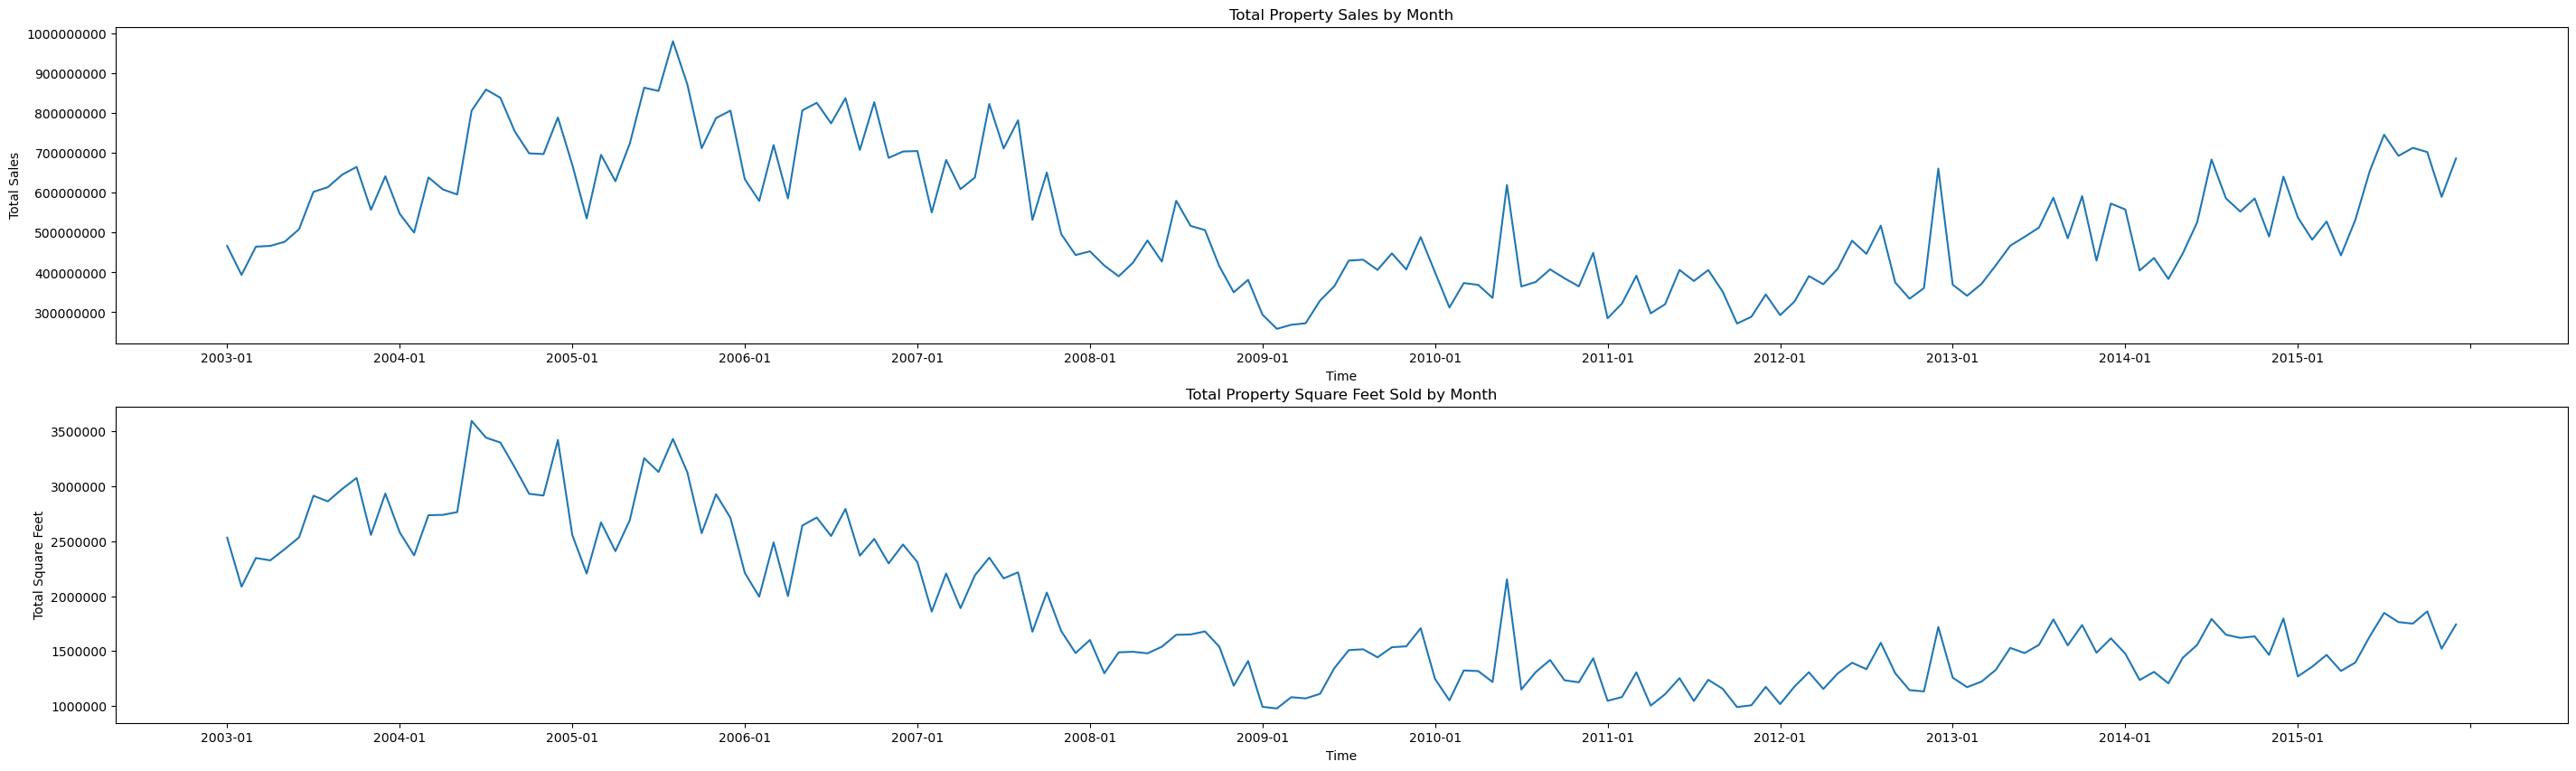

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(35, 10))
plt.sca(ax1)
plt.xticks(np.arange(0, 15 * 12, step=12))
plt.ticklabel_format(style="plain", axis="y")
sns.lineplot(x="month", y="total_sales", data=df_pandas)
plt.ylabel("Total Sales")
plt.xlabel("Time")
plt.title("Total Property Sales by Month")

plt.sca(ax2)
plt.xticks(np.arange(0, 15 * 12, step=12))
plt.ticklabel_format(style="plain", axis="y")
sns.lineplot(x="month", y="square_feet", data=df_pandas)
plt.ylabel("Total Square Feet")
plt.xlabel("Time")
plt.title("Total Property Square Feet Sold by Month")
plt.show()

#### Summary of observations from the exploratory data analysis

- The data shows a clear recurring pattern on a yearly cadence; this means the data has a **yearly seasonality**
- The summer months seem to have higher sales volumes compared to winter months
- In a comparison of years with high sales and years with low sales, the revenue difference between high sales months and low sales months in high sales years exceeds - in absolute terms - the revenue difference between high sales months and low sales months in low sale years. 

For example, in 2004, the revenue difference between the highest sales month and the lowest sales month is about

<br>

        $900,000,000 - $500,000,000 = $400,000,000

  and for 2011, that revenue difference calculation is about

<br>

        $400,000,000 - $300,000,000 = $100,000,000

  This becomes important later, when you must decide between **multiplicative** and **additive** seasonality effects.

## Step 4: Model training and tracking

### Model fitting

[Prophet](https://facebook.github.io/prophet/) input is always a two-column DataFrame. One input column is a time column named `ds`, and one input column is a value column named `y`. The time column should have a date, time, or datetime data format (e.g., `YYYY_MM`). The dataset here meets that condition. The value column must be a numerical data format.

For the model fitting, you must only rename the time column to `ds` and value column to `y`, and pass the data to Prophet. Read the [Prophet Python API documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api) for more information.

In [ ]:
df_pandas["ds"] = pd.to_datetime(df_pandas["month"])
df_pandas["y"] = df_pandas["total_sales"]

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 82, Finished, Available)

Prophet follows the [scikit-learn](https://scikit-learn.org/) convention. First, create a new instance of Prophet, set certain parameters (e.g.,`seasonality_mode`), and then fit that instance to the dataset.

- Although a constant additive factor is the default seasonality effect for Prophet, you should use the **'multiplicative' seasonality** for the seasonality effect parameter. The analysis in the previous section showed that because of changes in seasonality amplitude, a simple additive seasonality won't fit the data well at all.

- Set the **weekly_seasonality** parameter to **off**, because the data was aggregated by month. As a result, weekly data is not available.

- Use **Markov Chain Monte Carlo (MCMC)** methods to capture the seasonality uncertainty estimates. By default, Prophet can provide uncertainty estimates on the trend and observation noise, but not for the seasonality. MCMC require more processing time, but they allow the algorithm to provide uncertainty estimates on the seasonality, as well as the trend and observation noise. Read the [Prophet Uncertainty Intervals documentation](https://facebook.github.io/prophet/docs/uncertainty_intervals.html) for more information.

- Tune the automatic change point detection sensitivity through the **changepoint_prior_scale** parameter. The Prophet algorithm automatically tries to find instances in the data where the trajectories abruptly change. It can become difficult to find the correct value. To resolve this, you can try different values and then select the model with the best performance. Read the [Prophet Trend Changepoints documentation](https://facebook.github.io/prophet/docs/trend_changepoints.html) for more information.

In [ ]:
from prophet import Prophet

def fit_model(dataframe, seasonality_mode, weekly_seasonality, chpt_prior, mcmc_samples):
    m = Prophet(
        seasonality_mode=seasonality_mode,
        weekly_seasonality=weekly_seasonality,
        changepoint_prior_scale=chpt_prior,
        mcmc_samples=mcmc_samples,
    )
    m.fit(dataframe)
    return m

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 83, Finished, Available)

### Cross validation

Prophet has a built-in cross-validation tool. This tool can estimate the forecasting error, and find the model with the best performance.

The cross-validation technique can validate model efficiency. This technique trains the model on a subset of the dataset, and runs tests on a previously-unseen subset of the dataset. This technique can check how well a statistical model generalizes to an independent dataset.

For cross-validation, reserve a particular sample of the dataset, which was not part of the training dataset. Then, test the trained model on that sample, prior to deployment. However, this approach does not work for time-series data, because if the model has seen data from the months of January 2005 and March 2005, and you try to predict for the month February 2005, the model can essentially *cheat*, because it could see where the data trend leads. In real applications, the aim is to forecast for the **_future_**, as the unseen regions.

To handle this, and make the test reliable, split the dataset based on the dates. Use the dataset up to a certain date (e.g., the first eleven years of data) for training, and then use the remaining unseen data for prediction.

In this scenario, start with eleven years of training data, and then make monthly predictions using a one-year horizon. Specifically, the training data contains everything from 2003 through 2013. Then, the first run will handle predictions for January 2014 through January 2015. The next run handles predictions for February 2014 through February 2015, and so on.

Repeat this process for each of the three trained models, to see which model performs the best. Then, compare these predictions with real-world values, to establish the prediction quality of the best model.

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

def evaluation(m):
    df_cv = cross_validation(m, initial="4017 days", period="30 days", horizon="365 days")
    df_p = performance_metrics(df_cv, monthly=True)
    future = m.make_future_dataframe(periods=12, freq="M")
    forecast = m.predict(future)
    return df_p, future, forecast

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 84, Finished, Available)

### Log model with MLflow

Log the models, to keep track of their parameters, and save the models for later use. All relevant model information is logged in the workspace, under the experiment name. Note that the model, parameters, and metrics, along with MLflow autologging items, will be saved in one MLflow run.

In [ ]:
# Setup MLflow
from mlflow.models.signature import infer_signature

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 85, Finished, Available)

### Conduct experiments

A machine learning experiment serves as the primary unit of organization and control, for all related machine learning runs. A run corresponds to a single execution of model code. Machine learning experiment tracking refers to the management of all the different experiments and their components. This includes parameters, metrics, models and other artifacts, and it helps organize the the required components of a specific machine learning experiment. Machine learning experiment tracking also allows for the easy duplication of past results with saved experiments. Learn more about [machine learning experiments in Microsoft Fabric](https://aka.ms/synapse-experiment). Once you determine the steps you intend to include (e.g., fitting and evaluating the Prophet model in this notebook), you can run the experiment.

In [ ]:
model_name = f"{EXPERIMENT_NAME}-prophet"

models = []
df_metrics = []
forecasts = []
seasonality_mode = "multiplicative"
weekly_seasonality = False
changepoint_priors = [0.01, 0.05, 0.1]
mcmc_samples = 100

for chpt_prior in changepoint_priors:
    with mlflow.start_run(run_name=f"prophet_changepoint_{chpt_prior}"):
        # init model and fit
        m = fit_model(df_pandas, seasonality_mode, weekly_seasonality, chpt_prior, mcmc_samples)
        models.append(m)
        # Validation
        df_p, future, forecast = evaluation(m)
        df_metrics.append(df_p)
        forecasts.append(forecast)
        # Log model and parameters with MLflow
        mlflow.prophet.log_model(
            m,
            model_name,
            registered_model_name=model_name,
            signature=infer_signature(future, forecast),
        )
        mlflow.log_params(
            {
                "seasonality_mode": seasonality_mode,
                "mcmc_samples": mcmc_samples,
                "weekly_seasonality": weekly_seasonality,
                "changepoint_prior": chpt_prior,
            }
        )
        metrics = df_p.mean().to_dict()
        metrics.pop("horizon")
        mlflow.log_metrics(metrics)

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 86, Finished, Available)

22:57:49 - cmdstanpy - INFO - CmdStan start processing


Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
input tempfile: /tmp/tmp492qb1vd/pi85m3rt.json
input tempfile: /tmp/tmp492qb1vd/zvxk0g97.json
cmd: /nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin info
cwd: None
CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=44002', 'data', 'file=/tmp/tmp492qb1vd/pi85m3rt.json', 'init=/tmp/tmp492qb1vd/zvxk0g97.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_model5exb11ha/prophet_model-20230907225749_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=44002', 'data', 'file=/tmp/tmp492qb1vd/pi85m3rt.json', 'init=/tmp/tmp492qb1vd/zvxk0g97.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_model5exb11ha/prophet_model-20230907225749_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:57:51 - cmdstanpy - INFO - CmdStan done processing.
22:57:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 

  0%|          | 0/12 [00:00<?, ?it/s]

22:57:51 - cmdstanpy - INFO - CmdStan start processing


input tempfile: /tmp/tmp492qb1vd/rfto5sjq.json
input tempfile: /tmp/tmp492qb1vd/4c5lejg_.json
cmd: /nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin info
cwd: None
CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=13326', 'data', 'file=/tmp/tmp492qb1vd/rfto5sjq.json', 'init=/tmp/tmp492qb1vd/4c5lejg_.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modeluosl8b5f/prophet_model-20230907225751_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=13326', 'data', 'file=/tmp/tmp492qb1vd/rfto5sjq.json', 'init=/tmp/tmp492qb1vd/4c5lejg_.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modeluosl8b5f/prophet_model-20230907225751_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:57:53 - cmdstanpy - INFO - CmdStan done processing.
22:57:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=8093', 'data', 'file=/tmp/tmp492qb1vd/5ymhivit.json', 'init=/tmp/tmp492qb1vd/w8jm1i1h.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_model7ehfiljz/prophet_model-20230907225753_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=8093', 'data', 'file=/tmp/tmp492qb1vd/5ymhivit.json', 'init=/tmp/tmp492qb1vd/w8jm1i1h.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_model7ehfiljz/prophet_model-20230907225753_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/nfs

22:57:55 - cmdstanpy - INFO - CmdStan done processing.
22:57:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=11882', 'data', 'file=/tmp/tmp492qb1vd/ris07pq8.json', 'init=/tmp/tmp492qb1vd/6xt4v4zc.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelyp5n5lgd/prophet_model-20230907225755_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=11882', 'data', 'file=/tmp/tmp492qb1vd/ris07pq8.json', 'init=/tmp/tmp492qb1vd/6xt4v4zc.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelyp5n5lgd/prophet_model-20230907225755_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:57:57 - cmdstanpy - INFO - CmdStan done processing.
22:57:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=89854', 'data', 'file=/tmp/tmp492qb1vd/lmue2vpk.json', 'init=/tmp/tmp492qb1vd/vz7wwqti.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelkq2xwtw7/prophet_model-20230907225758_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=89854', 'data', 'file=/tmp/tmp492qb1vd/lmue2vpk.json', 'init=/tmp/tmp492qb1vd/vz7wwqti.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelkq2xwtw7/prophet_model-20230907225758_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:58:00 - cmdstanpy - INFO - CmdStan done processing.
22:58:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=74949', 'data', 'file=/tmp/tmp492qb1vd/_uik37ky.json', 'init=/tmp/tmp492qb1vd/30dnuu10.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_model45gqkpz8/prophet_model-20230907225800_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=74949', 'data', 'file=/tmp/tmp492qb1vd/_uik37ky.json', 'init=/tmp/tmp492qb1vd/30dnuu10.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_model45gqkpz8/prophet_model-20230907225800_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:58:02 - cmdstanpy - INFO - CmdStan done processing.
22:58:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=47557', 'data', 'file=/tmp/tmp492qb1vd/w38l_vif.json', 'init=/tmp/tmp492qb1vd/5l6vkvoe.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelefgomj6e/prophet_model-20230907225802_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=47557', 'data', 'file=/tmp/tmp492qb1vd/w38l_vif.json', 'init=/tmp/tmp492qb1vd/5l6vkvoe.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelefgomj6e/prophet_model-20230907225802_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:58:04 - cmdstanpy - INFO - CmdStan done processing.
22:58:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=1571', 'data', 'file=/tmp/tmp492qb1vd/_41vdxvp.json', 'init=/tmp/tmp492qb1vd/kctfsr8l.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modeltin56gze/prophet_model-20230907225804_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=1571', 'data', 'file=/tmp/tmp492qb1vd/_41vdxvp.json', 'init=/tmp/tmp492qb1vd/kctfsr8l.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modeltin56gze/prophet_model-20230907225804_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/nfs

22:58:06 - cmdstanpy - INFO - CmdStan done processing.
22:58:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=75812', 'data', 'file=/tmp/tmp492qb1vd/q8imkqyv.json', 'init=/tmp/tmp492qb1vd/pihq55gp.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelg5q0jwy_/prophet_model-20230907225806_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=75812', 'data', 'file=/tmp/tmp492qb1vd/q8imkqyv.json', 'init=/tmp/tmp492qb1vd/pihq55gp.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelg5q0jwy_/prophet_model-20230907225806_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:58:09 - cmdstanpy - INFO - CmdStan done processing.
22:58:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=92733', 'data', 'file=/tmp/tmp492qb1vd/f3fs1lrv.json', 'init=/tmp/tmp492qb1vd/6w20gzd3.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelam_a4iz4/prophet_model-20230907225809_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=92733', 'data', 'file=/tmp/tmp492qb1vd/f3fs1lrv.json', 'init=/tmp/tmp492qb1vd/6w20gzd3.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelam_a4iz4/prophet_model-20230907225809_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:58:11 - cmdstanpy - INFO - CmdStan done processing.
22:58:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=93086', 'data', 'file=/tmp/tmp492qb1vd/jb_v3uvi.json', 'init=/tmp/tmp492qb1vd/g8n_3ilh.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modeljfmmtxc4/prophet_model-20230907225811_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=93086', 'data', 'file=/tmp/tmp492qb1vd/jb_v3uvi.json', 'init=/tmp/tmp492qb1vd/g8n_3ilh.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modeljfmmtxc4/prophet_model-20230907225811_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:58:13 - cmdstanpy - INFO - CmdStan done processing.
22:58:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=99807', 'data', 'file=/tmp/tmp492qb1vd/yga24lzq.json', 'init=/tmp/tmp492qb1vd/xj7yf3e5.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_model0bwthnsa/prophet_model-20230907225813_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=99807', 'data', 'file=/tmp/tmp492qb1vd/yga24lzq.json', 'init=/tmp/tmp492qb1vd/xj7yf3e5.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_model0bwthnsa/prophet_model-20230907225813_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:58:15 - cmdstanpy - INFO - CmdStan done processing.
22:58:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=40289', 'data', 'file=/tmp/tmp492qb1vd/xvsruvl2.json', 'init=/tmp/tmp492qb1vd/d30s3s8x.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelfl801oeb/prophet_model-20230907225815_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=40289', 'data', 'file=/tmp/tmp492qb1vd/xvsruvl2.json', 'init=/tmp/tmp492qb1vd/d30s3s8x.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelfl801oeb/prophet_model-20230907225815_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:58:17 - cmdstanpy - INFO - CmdStan done processing.
22:58:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=39495', 'data', 'file=/tmp/tmp492qb1vd/f9_hzflb.json', 'init=/tmp/tmp492qb1vd/5n03o_ni.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modeln6i_zst6/prophet_model-20230907225824_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=39495', 'data', 'file=/tmp/tmp492qb1vd/f9_hzflb.json', 'init=/tmp/tmp492qb1vd/5n03o_ni.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modeln6i_zst6/prophet_model-20230907225824_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:58:25 - cmdstanpy - INFO - CmdStan done processing.
22:58:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 

  0%|          | 0/12 [00:00<?, ?it/s]

22:58:25 - cmdstanpy - INFO - CmdStan start processing


input tempfile: /tmp/tmp492qb1vd/m3zdn8hu.json
input tempfile: /tmp/tmp492qb1vd/gi5ybr66.json
cmd: /nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin info
cwd: None
CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=63735', 'data', 'file=/tmp/tmp492qb1vd/m3zdn8hu.json', 'init=/tmp/tmp492qb1vd/gi5ybr66.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelf5u6dkm0/prophet_model-20230907225825_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=63735', 'data', 'file=/tmp/tmp492qb1vd/m3zdn8hu.json', 'init=/tmp/tmp492qb1vd/gi5ybr66.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelf5u6dkm0/prophet_model-20230907225825_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:58:26 - cmdstanpy - INFO - CmdStan done processing.
22:58:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 13

chain 1 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=74081', 'data', 'file=/tmp/tmp492qb1vd/yam05po7.json', 'init=/tmp/tmp492qb1vd/09i6q0bu.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelw83fjre_/prophet_model-20230907225828_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=74081', 'data', 'file=/tmp/tmp492qb1vd/yam05po7.json', 'init=/tmp/tmp492qb1vd/09i6q0bu.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelw83fjre_/prophet_model-20230907225828_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:58:29 - cmdstanpy - INFO - CmdStan done processing.
22:58:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=78823', 'data', 'file=/tmp/tmp492qb1vd/4ju8u82e.json', 'init=/tmp/tmp492qb1vd/edf7piq9.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelh4a32myz/prophet_model-20230907225845_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=78823', 'data', 'file=/tmp/tmp492qb1vd/4ju8u82e.json', 'init=/tmp/tmp492qb1vd/edf7piq9.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelh4a32myz/prophet_model-20230907225845_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:58:47 - cmdstanpy - INFO - CmdStan done processing.
22:58:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/diagnostics.py:141: FutureWarning: Units 

  0%|          | 0/12 [00:00<?, ?it/s]

22:58:49 - cmdstanpy - INFO - CmdStan start processing



CmdStan done processing.
runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=15111', 'data', 'file=/tmp/tmp492qb1vd/pebs3_79.json', 'init=/tmp/tmp492qb1vd/ju2jnzl4.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_model16j0bfrh/prophet_model-20230907225848_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp492qb1vd/prophet_model16j0bfrh/prophet_model-20230907225848_1.csv
 console_msgs (if any):
	/tmp/tmp492qb1vd/prophet_model16j0bfrh/prophet_model-20230907225848_0-stdout.txt
Chain 1 console:
method = sample (Default)
  sample
    num_samples = 50
    num_warmup = 50
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

idx 0
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=16831', 'data', 'file=/tmp/tmp492qb1vd/tcdsg52d.json', 'init=/tmp/tmp492qb1vd/ls3znfvj.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelb_z4zloz/prophet_model-20230907225852_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 1
running CmdStan, num_threads: 1
CmdStan args: ['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=16831', 'data', 'file=/tmp/tmp492qb1vd/tcdsg52d.json', 'init=/tmp/tmp492qb1vd/ls3znfvj.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_modelb_z4zloz/prophet_model-20230907225852_2.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
idx 2
running CmdStan, num_threads: 1
CmdStan args: ['/n

22:58:55 - cmdstanpy - INFO - CmdStan done processing.
22:58:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 

chain 1 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                
CmdStan done processing.
runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/nfs4/pyenv-bf23644b-8f57-4e49-8bc8-db05cf6bda54/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=98898', 'data', 'file=/tmp/tmp492qb1vd/jr8zc4jk.json', 'init=/tmp/tmp492qb1vd/5gj09zn4.json', 'output', 'file=/tmp/tmp492qb1vd/prophet_model63o39x8c/prophet_model-20230907225900_1.csv', 'method=sample', 'num_samples=50', 'num_warmup=50', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp492qb1vd/prophet_model63o39x8c/prophet_model-20230907225900_1

22:59:00 - cmdstanpy - INFO - CmdStan done processing.
22:59:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/project/python/build/lib.linux-x86_64-cpython-37/prophet/stan_model/cmdstan-2.31.0/prophet.stan', line 137,

chain 1 |          | 00:00 Status

2023/09/07 22:59:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: aisample-timeseries-prophet, version 24
Created version '24' of model 'aisample-timeseries-prophet'.


<img src="https://synapseaisolutionsa.blob.core.windows.net/public/NYC_Property_Sales_Dataset/Timeseries-experiment.png"  width="70%" height="30%">

### Visualize a model with Prophet

Prophet has built-in visualization functions which can show the model fitting results. 

The black dots denote the data points that are used to train the model. The blue line is the prediction, and the light blue area shows the uncertainty intervals. Note that you have built three models with different `changepoint_prior_scale` values. The predictions of these three models are shown below.

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 87, Finished, Available)

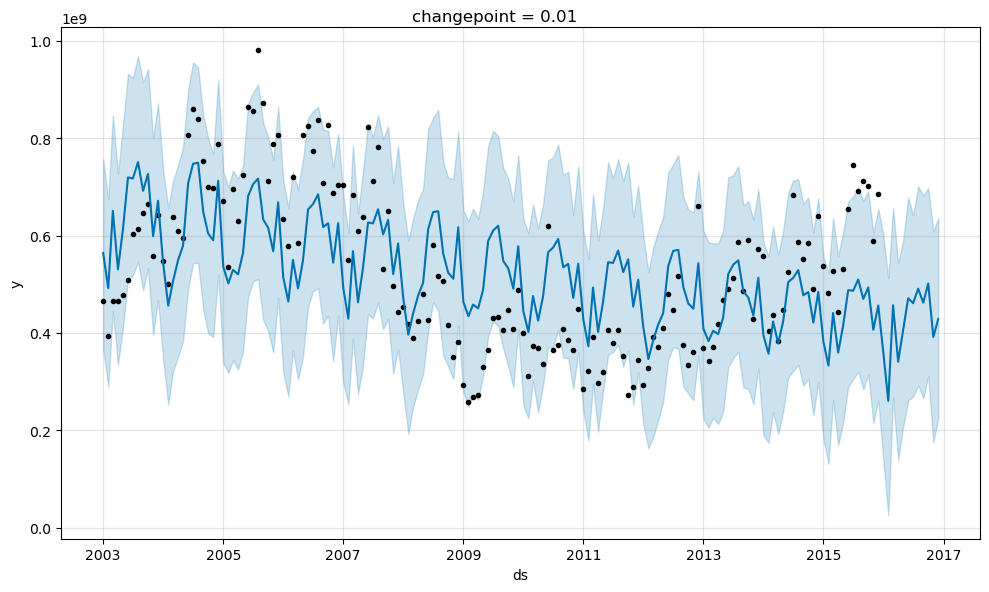

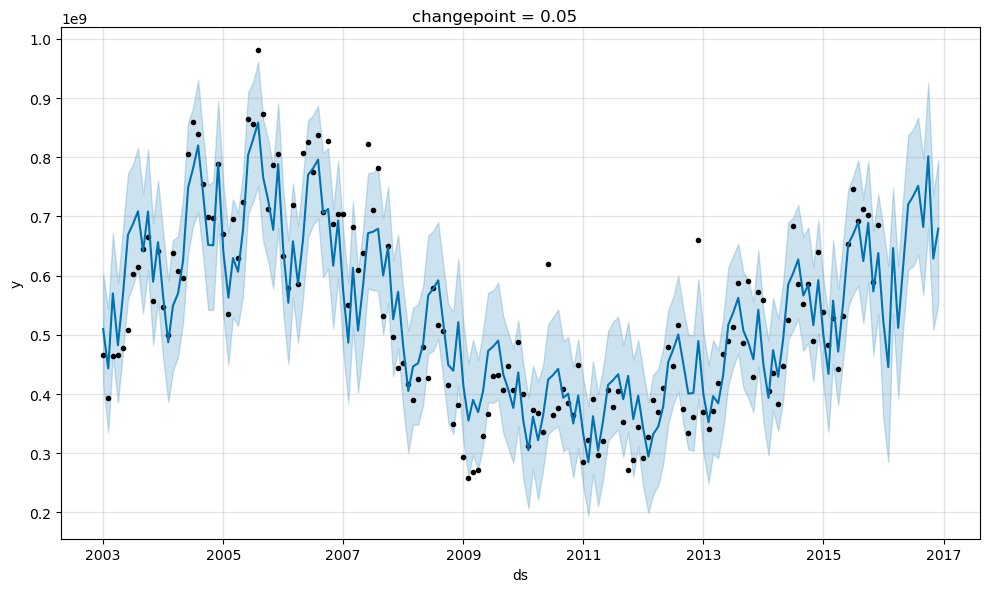

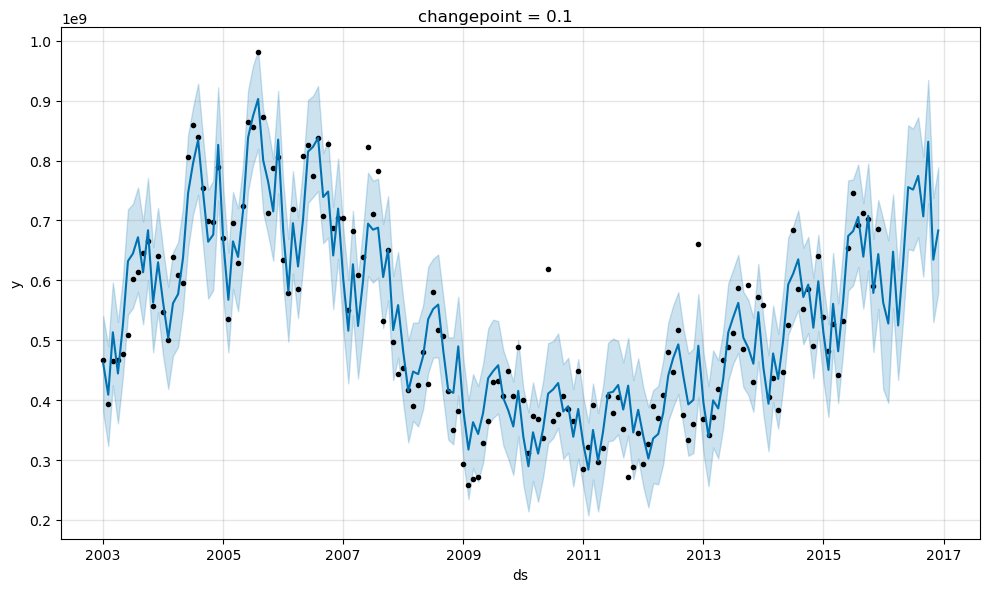

In [ ]:
for idx, pack in enumerate(zip(models, forecasts)):
    m, forecast = pack
    fig = m.plot(forecast)
    fig.suptitle(f"changepoint = {changepoint_priors[idx]}")

The smallest `changepoint_prior_scale` value in the first graph leads to an underfitting of trend changes. The largest `changepoint_prior_scale` in the third graph may result in overfitting. Consequently, the second graph seems to be the optimal choice. This implies that the second model is the most suitable.

### Visualize trends and seasonality with Prophet

Prophet can also easily visualize the underlying trends and seasonalities. Visualizations of the second model are shown below.

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 88, Finished, Available)

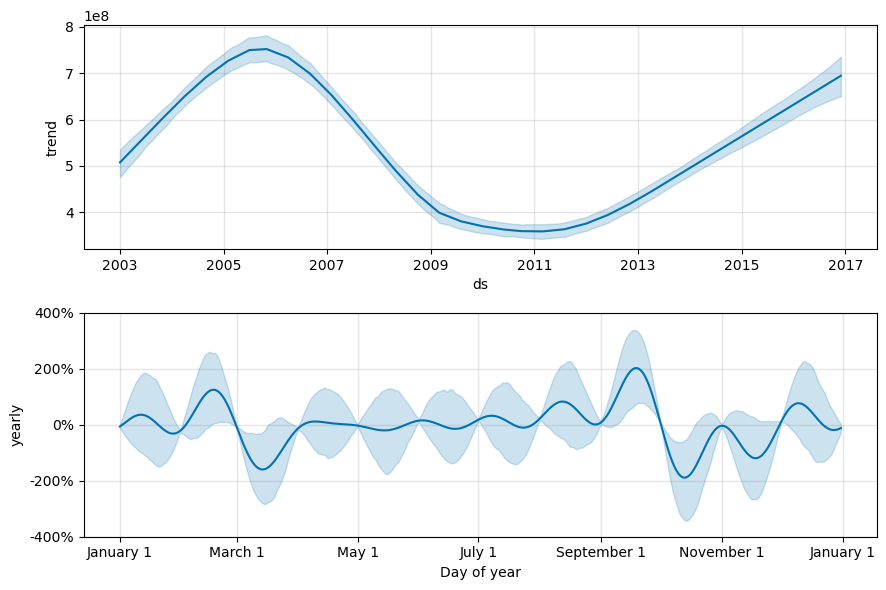

In [ ]:
BEST_MODEL_INDEX = 1  # Set the best model index according to the previous results
fig2 = models[BEST_MODEL_INDEX].plot_components(forecast)

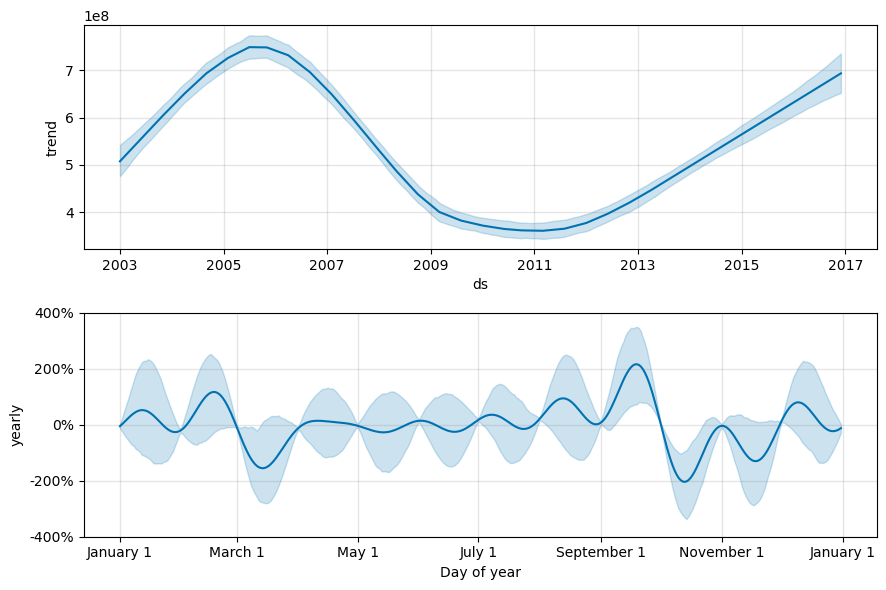

In these graphs, the light blue shading reflects the uncertainty. The top graph shows a strong, long-period oscillating trend. Over a few years, the sales volumes rise and fall. The lower graph shows that sales tend to peak in February and September, reaching their maximum values for the year in those momths. Shortly after those months, in March and October, they fall to the year's minimum values.

Evaluate the performance of the models using various metrics, for example:

- mean squared error (MSE)
- root mean squared error (RMSE)
- mean absolute error (MAE)
- mean absolute percent error (MAPE)
- median absolute percent error (MDAPE)
- symmetric mean absolute percentage error (SMAPE)

Evaluate the coverage using the `yhat_lower` and `yhat_upper` estimates. Note the varying horizons where you predict one year in the future, twelve times.

In [ ]:
display(df_metrics[BEST_MODEL_INDEX])

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 89, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


SynapseWidget(Synapse.DataFrame, 286f4d91-4465-41c6-8245-012749700d14)

With the MAPE metric, for this forecasting model, predictions that extend one month into the future typically involve errors of roughly 8%. However, for predictions one year into the future, the error increases to roughly 10%.

## Step 5: Score the model and save prediction results

Now score the model, and save the prediction results.


#### Make predictions with Predict Transformer

Now, you can load the model and use it to make predictions. Users can operationalize machine learning models with **PREDICT**, a scalable Microsoft Fabric function that supports batch scoring in any compute engine. Learn more about ```PREDICT```, and how to use it within Microsoft Fabric, at [this resource](https://aka.ms/fabric-predict).

In [ ]:
from synapse.ml.predict import MLFlowTransformer

spark.conf.set("spark.synapse.ml.predict.enabled", "true")

model = MLFlowTransformer(
    inputCols=future.columns.values,
    outputCol="prediction",
    modelName=f"{EXPERIMENT_NAME}-prophet",
    modelVersion=BEST_MODEL_INDEX,
)

test_spark = spark.createDataFrame(data=future, schema=future.columns.to_list())

batch_predictions = model.transform(test_spark)

display(batch_predictions)

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 90, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.


SynapseWidget(Synapse.DataFrame, d5570bf6-80a5-43e9-aedd-5334e9eb0a9c)

In [ ]:
# Code for saving predictions into lakehouse
batch_predictions.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/batch_predictions"
)

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 91, Finished, Available)

In [ ]:
# Determine the entire runtime
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, fd80f5c8-b3bb-4818-9285-575b2217270e, 92, Finished, Available)

Full run cost 114 seconds.
